# 1. Biocellion Sensitivity Analysis - Sample
This notebook defines functions to sample input parameters, run simulations and do a sensitivity analysis for the Biocellion ABM models by the CMMC that can be found in github.com/TheCMMC. For more information on the CMMC, visit www.thecmmc.org.  


In [1]:
import matplotlib.pyplot as plt
import paraview.simple as pvs
import pandas as pd
import numpy as np
import math
from pathlib import Path
from SALib.sample.morris import sample as morris_sample
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
    sample_histograms

## User settings

In [2]:
# Set this data folder to the place where you cloned the repository https://github.com/TheCMMC/biocellion-data
DATA_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-data")
MODEL_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user")
TOOLS_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-tools")
FIG_FOLDER = Path("./figures")

In [3]:
ABM_CFD_DATA_FOLDER = DATA_FOLDER / "PLOSone_ABM-CFD-microcarrier"
ABM_CFD_MODEL_FOLDER = MODEL_FOLDER / "ABM-microcarriers"
ABM_CFD_PARAMETER_FILE = TOOLS_FOLDER / "SensitivityAnalysis_ABM-CFD_ParameterInfo.csv"

In [ ]:
SEED = 20190605  # Set seed for random number generation to be the date of the first seattle meeting

## Sample the parameter space
We use Morris sampling method to sample the parameter space. It starts at a certain parameter set and generates new ones by changing one at a time. In this way a trajectory through parameter space is set out. By choosing a number of these trajectories in a smart way, the parameter space is sampled evenly. For more information on this method see [Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804) and [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805). We use the package SALib that implements this and other methods along with various helper function. For more information on SALib see [the documentation](https://salib.readthedocs.io/en/latest/).

In [5]:
param_info = pd.read_csv(ABM_CFD_PARAMETER_FILE)
param_info

,Description,name,range_min,range_max,range_type,file,type,manuscript value
0,NaN,STRESS_HILL_EXPONENT,1.000000e+00,10.000000,linear,model_define.h,REAL,NaN
1,NaN,MECH_STRESS_TRESHOLD_DEATH,1.000000e-07,0.000010,exponential,model_define.h,REAL,NaN
2,NaN,STRESS_TRESHOLD,1.000000e-08,0.000001,exponential,model_define.h,REAL,NaN
3,Cell-cell spring constant,A_AGENT_STIFFNESS_CC,1.000000e-04,0.010000,exponential,model_define.h,REAL,0.0010
4,Cell-cell bond flexibility,A_AGENT_BOND_S_CC,1.000000e-02,0.900000,exponential,model_define.h,REAL,0.2000
5,Thresholding factor for cell-cell bond breaking,A_AGENT_BOND_DESTROY_FACTOR_CC,1.000000e+00,1.500000,linear,model_define.h,REAL,1.1000
6,Cell-microcarrier spring constant,A_AGENT_STIFFNESS_CM,2.200000e-04,0.022000,expenential,model_define.h,REAL,0.0022
7,Cell-microcarrier bond flexibility,A_AGENT_BOND_S_CM,1.000000e-02,0.900000,exponential,model_define.h,REAL,0.2000
8,Thresholding factor for cell-microcarrier bond...,A_AGENT_BOND_DESTROY_FACTOR_CM,1.000000e+00,1.500000,linear,model_define.h,REAL,1.1000


In [ ]:
# class ParameterSample:
#     def __init__(self, model_folder, sample_output_folder, param_info_file):
## TODO finish class  

In [6]:
def sample_morris_parameters(parameters, num_levels=4, optimal_trajectories=None, seed=None):
    exp10_select = parameters.loc[parameters.range_type=="exponential", ["range_min", "range_max"]]
    parameters.update(np.log10(exp10_select))
#     print(parameters)

    problem = {
      'num_vars': len(parameters),
      'names': parameters["name"].values.tolist(),
      'bounds': parameters[["range_min","range_max"]].values.tolist()
    }

    param_sample = morris_sample(problem, 10, num_levels=4, optimal_trajectories=optimal_trajectories, seed=SEED)
#     print(param_values)
    for param_vec in param_sample:
        for i in parameters.loc[parameters.range_type=="exponential"].index:
            param_vec[i] = 10**param_vec[i]
    return param_sample, problem

In [15]:
param_sample, problem = sample_morris_parameters(param_info, seed=SEED)

print(np.shape(param_sample))
print(f"This analysis needs approx. {np.round((len(param_sample)*2)/24,1)} days")

(100, 9)
This analysis needs approx. 8.3 days


In [16]:
def sample_scatterplot(x, y, df, problem, param_info):
    if type(x) == int:
        xname = problem["names"][x]
    elif type(x) == str:
        xname = x
    if type(y) == int:
        yname = problem["names"][y]
    elif type(y) == str:
        yname = y
    assert xname in problem["names"]
    assert yname in problem["names"]

    df.plot(problem["names"][x], problem["names"][y], kind="scatter")
    if (param_info.loc[param_info["name"]==xname, "range_type"] == "exponential").values[0]:
        plt.xscale("log")
    if (param_info.loc[param_info["name"]==yname, "range_type"] == "exponential").values[0]:
        plt.yscale("log")
    

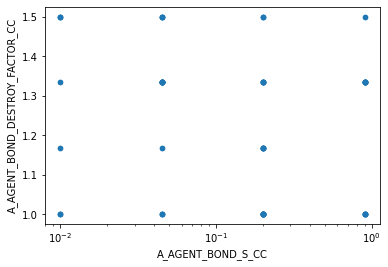

In [18]:
param_sample_df = pd.DataFrame(param_sample, columns=problem["names"])
rng = np.random.default_rng(SEED)
choice = rng.choice(range(len(param_info)), size=2, replace=False)
sample_scatterplot(int(choice[0]), int(choice[1]), param_sample_df, problem, param_info)

## Run biocellion simulations
Now that we have sampled the parameters, we can run all simulations for these parameter sets. We need to fill in the paramater values in the correct place in the biocellion files and compile the model. Then run the model and store the results. The output of each run will get a unique time stamp and a parameter file that contains the parameters for that run. 

In [29]:
import os
import re
from datetime import datetime
import xml.etree.ElementTree as ET
from itertools import chain

class Model:
    def __init__(self, param_vector, model_folder, output_base_folder, problem, param_info, num_steps=None):
        self.param_vector = param_vector
        self.model_folder = model_folder
        self.output_base_folder = output_base_folder
        self.problem = problem
        self.param_info = param_info
        self.num_steps = num_steps
        
        self.init_time = None
        self.timestamp = None
        self.xml = None
        self.xml_path = None
        self.output_location = None
        
        self._set_timestamp()
        
        
    def _set_timestamp(self):
        self.init_time = datetime.now()
        self.timestamp = self.init_time.strftime("%Y%m%d-%H%M%S")


    def _prepare_xml(self):
        """Read original xml file and write to timestamped new file"""

        base_xml_path = self.model_folder / "run_model.xml"
        self.xml = ET.parse(base_xml_path)
        self.xml_path = base_xml_path.with_stem(f"run_model_{self.timestamp}")
        self.xml.write(self.xml_path)

    def _prepare_output_location(self):
        """Creates new timestamped folder and renames output paths in xml file"""

        self.output_location = self.output_base_folder / f"output_{self.timestamp}"
        os.mkdir(self.output_location)

        #  rename the output paths 
        root = self.xml.getroot()
        for element in chain(root.iter("output"), root.iter("stdout")):
            element.set("path", str(self.output_location))
        self.xml.write(self.xml_path)
        
    def _write_simulation_info(self):
        param_sample_df = pd.DataFrame([self.param_vector], columns=self.problem["names"])
        param_sample_df.to_csv(self.output_location / f"parameters_{self.timestamp}.csv")

    def _set_num_steps(self):
        """Creates new timestamped folder and renames output paths in xml file"""

        root = self.xml.getroot()
        for element in root.iter("time_step"):
            element.set("end", str(self.num_steps))
        self.xml.write(self.xml_path)        
        

    def _enter_parameter(self, index, value):
        info = self.param_info.loc[index]
        parameter_loc = self.model_folder / info["file"]
        param_type, param_name = info["type"], info["name"]
        string = f"const {param_type} {param_name} = .+ ;" 
        pattern = re.compile(string)
        new_string = f"const {param_type} {param_name} = {value} ;"
        
        with open(parameter_loc, "r") as file:
            content = file.read()
            assert re.search(pattern, content)
            content = re.sub(pattern, new_string, content)
            
        with open(parameter_loc, "w") as file:
            file.write(content) 
        
        
    def prepare(self):
        """Enters the parameter values and output locations in the right file and place, then compiles the model."""

        print(f"Preparing model at {self.init_time}")
        self._prepare_xml()
        self._prepare_output_location()
        self._write_simulation_info()
        if self.num_steps:
            self._set_num_steps()
        for i, value in enumerate(self.param_vector):
            self._enter_parameter(i, value)
        print(f"Output will be collected in: \n {self.output_location}")


    def build(self):
        """Builds the model using make, after cleaning up the previous build"""
        print("Building the model...")
        cwd = os.getcwd()
        os.chdir(self.model_folder)
        
        os.system("make clean")
        os.system("make -s")

        os.chdir(cwd)

        
    def run(self):
        print(f"Starting simulation with {self.xml_path.stem}")
        cwd = os.getcwd()
        os.chdir(self.model_folder)
        !biocellion {self.xml_path}
        os.chdir(cwd)
        os.rename(self.xml_path, self.output_location / self.xml_path.name)


In [30]:
output_base_folder = ABM_CFD_MODEL_FOLDER / "output"
model = Model(param_sample[0], ABM_CFD_MODEL_FOLDER, output_base_folder, problem, param_info, num_steps=101)
model.prepare()
model.build()
model.run()

Preparing model at 2021-06-21 17:33:00.371283
Output will be collected in: 
 /home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output/output_20210621-173300
Building the model...
Starting simulation with run_model_20210621-173300
WARNING, this binary does not support distributed memory parallelism, and "num_node_groups" (child element of "system") will be ignored.
WARNING, this binary does not support distributed memory parallelism, and "num_nodes_per_group" (child element of "system") will be ignored.
WARNING, this binary does not support distributed memory parallelism, and "num_sockets_per_node" (child element of "system") will be ignored.
WARNING, this binary does not support distributed memory parallelism, and "load_balance" (attribute of "interval") will be ignored.
Reading Velocity_220rpm.txt...  read 291016 points.


In [65]:
def run_batch(param_vectors, problem, param_info, model_folder, num_steps=101):
    # Create the parameter sample file to be able to rerun the same batch
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    batch_output_folder = model_folder / f"output_{timestamp}"
    os.mkdir(batch_output_folder)
    param_sample_df = pd.DataFrame(param_vectors, columns=problem["names"])
    param_sample_df.to_csv(batch_output_folder / f"parameter_sample_{timestamp}.csv")
    
    for i, param_vector in enumerate(param_vectors):
        print(f"Starting run for parameter set {i}")
        model = Model(param_vector, model_folder, batch_output_folder, problem, param_info, num_steps=num_steps)
        model.prepare()
        model.build()
        model.run()
        print("---------------- \n")

In [ ]:
run_batch(param_sample, problem, param_info, ABM_CFD_MODEL_FOLDER, num_steps=120000)

Starting run for parameter set 0
Preparing model at 2021-06-04 17:59:35.226399
Output will be collected in: 
 /home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output_20210604-175935/output_20210604-175935
Building the model...
Starting simulation with run_model_20210604-175935
WARNING, this binary does not support distributed memory parallelism, and "num_node_groups" (child element of "system") will be ignored.
WARNING, this binary does not support distributed memory parallelism, and "num_nodes_per_group" (child element of "system") will be ignored.
WARNING, this binary does not support distributed memory parallelism, and "num_sockets_per_node" (child element of "system") will be ignored.
WARNING, this binary does not support distributed memory parallelism, and "load_balance" (attribute of "interval") will be ignored.
Reading Velocity_220rpm.txt...  read 291016 points.
termination took 0.0002 seconds.
Simulation finished.
----